<a href="https://colab.research.google.com/github/tanwm98/INF2008_P2_3_ML/blob/Sadim_touch_V3/INF2008_Machine_Learning_P2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-prerequisite
1. Create Folder named dataset
2. Upload file named combined_dataset.csv (https://github.com/tanwm98/INF2008_P2_3_ML/raw/refs/heads/Sadim_touch_V3/dataset/combined_dataset.csv)

## Linear Regression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Loading data...

Dataset shape: (2513, 8)

First few rows:
        Date         Gold     Silver  Crude Oil        DXY       S&P500  \
0 2015-01-02  1186.000000  15.734000  52.689999  91.080002  2058.199951   
1 2015-01-05  1203.900024  16.179001  50.040001  91.379997  2020.579956   
2 2015-01-06  1219.300049  16.603001  47.930000  91.500000  2002.609985   
3 2015-01-07  1210.599976  16.510000  48.650002  91.889999  2025.900024   
4 2015-01-08  1208.400024  16.351000  48.790001  92.370003  2062.139893   

       cpi     rates  
0  234.747  0.114839  
1  234.747  0.114839  
2  234.747  0.114839  
3  234.747  0.114839  
4  234.747  0.114839  

Generating correlation heatmap...


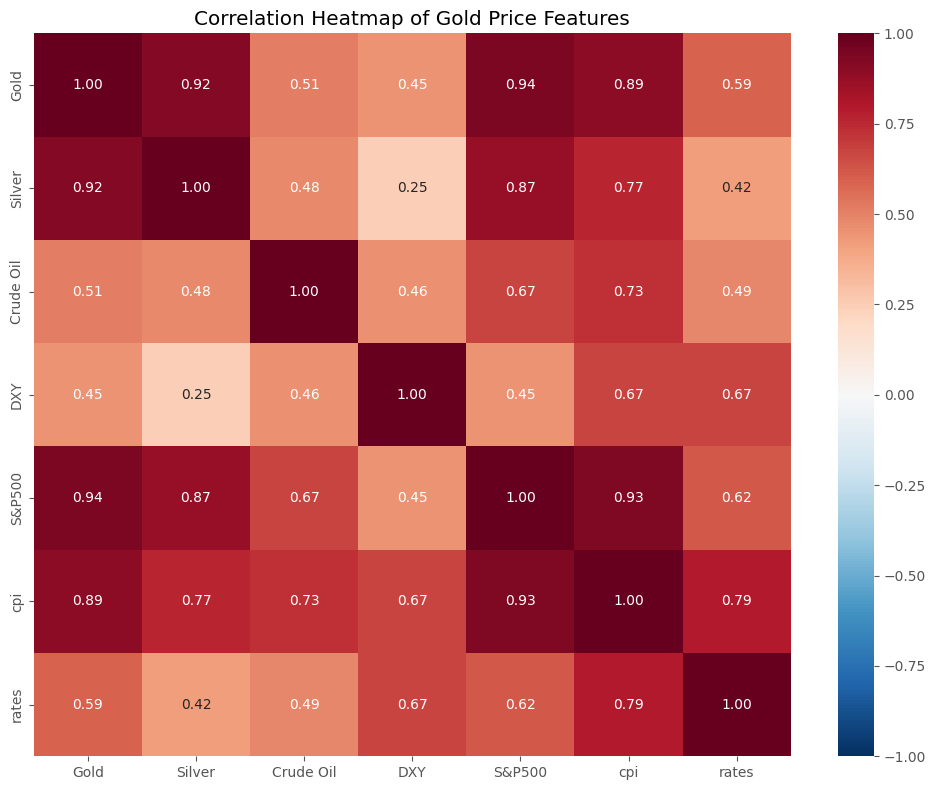


Preparing data for modeling with train/validation/test split...
- S&P500
- Silver
Final features used in model training:
- Crude Oil
- DXY
- cpi
- rates
- Silver_Pct_1
- Silver_Accel_1
- Silver_Pct_3
- Silver_Accel_3
- Silver_Pct_6
- Silver_Accel_6
- Silver_Pct_12
- Silver_Vol_5
- Silver_Vol_10
- Silver_Vol_20
- Silver_MA_Ratio_10
- Silver_MA_Ratio_20
- S&P500_Pct_1
- S&P500_Accel_1
- S&P500_Pct_3
- S&P500_Accel_3
- S&P500_Pct_6
- S&P500_Accel_6
- S&P500_Pct_12
- S&P500_Vol_5
- S&P500_Vol_10
- S&P500_Vol_20
- S&P500_MA_Ratio_10
- S&P500_MA_Ratio_20
- Crude Oil_Pct_1
- Crude Oil_Accel_1
- Crude Oil_Pct_3
- Crude Oil_Accel_3
- Crude Oil_Pct_6
- Crude Oil_Accel_6
- Crude Oil_Pct_12
- Crude Oil_Vol_5
- Crude Oil_Vol_10
- Crude Oil_Vol_20
- Crude Oil_MA_Ratio_10
- Crude Oil_MA_Ratio_20
- DXY_Pct_1
- DXY_Accel_1
- DXY_Pct_3
- DXY_Accel_3
- DXY_Pct_6
- DXY_Accel_6
- DXY_Pct_12
- DXY_Vol_5
- DXY_Vol_10
- DXY_Vol_20
- DXY_MA_Ratio_10
- DXY_MA_Ratio_20
- rates_Pct_1
- rates_Accel_1
- rates_Pct_

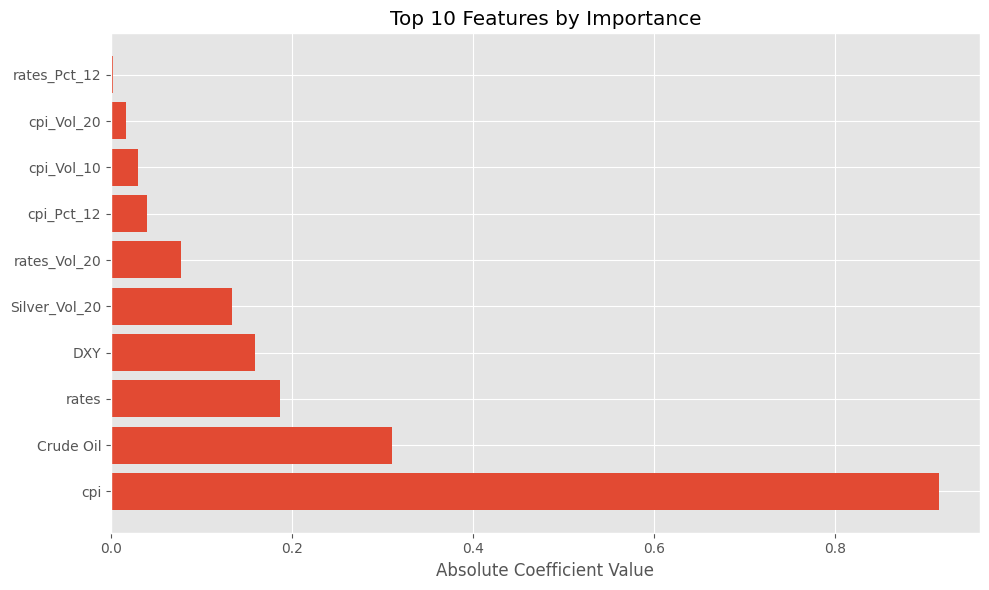

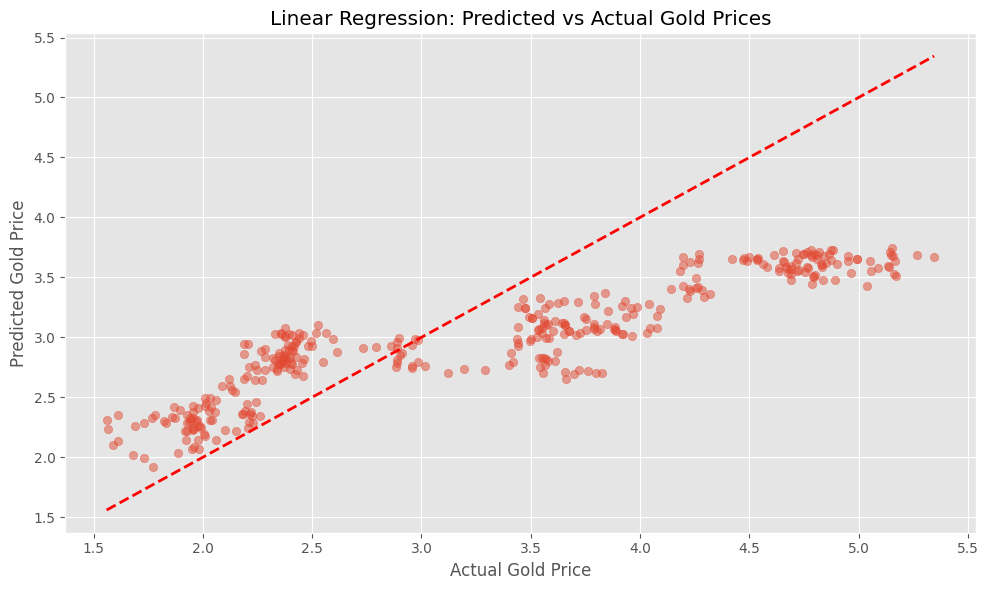

Metrics on Original Scale:
R²: 0.52434
MAE: 164.40
MSE: 36289.21
RMSE: 190.50
EVS: 0.60274


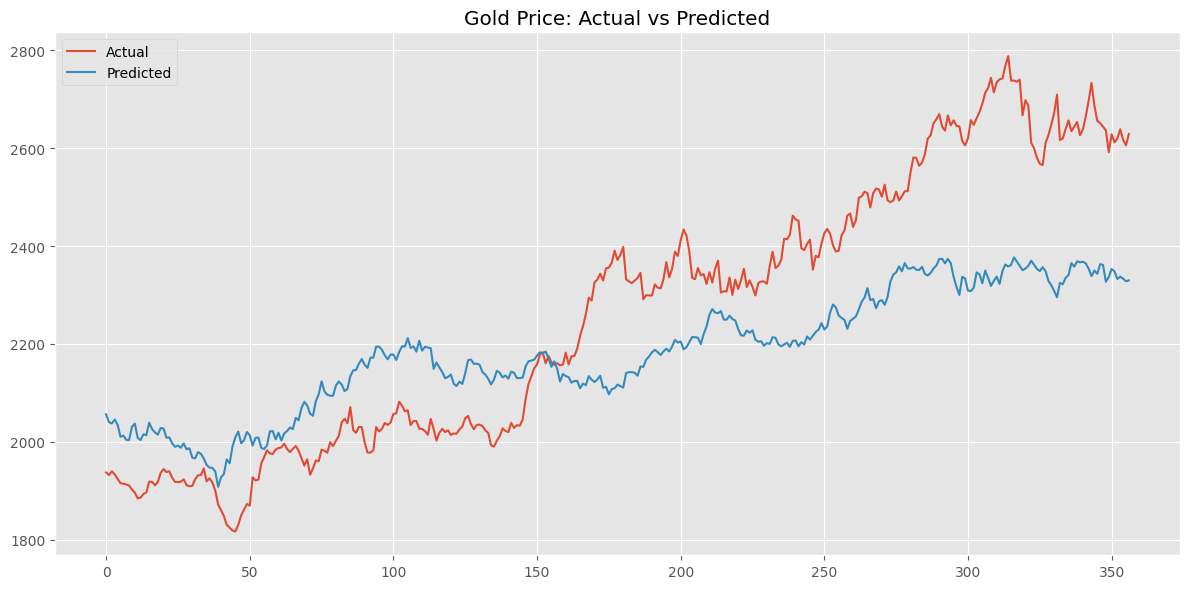

In [ ]:
import warnings
import matplotlib

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression


def load_data(file_path):
    # Read the dataset
    df = pd.read_csv(file_path)

    # Select columns from the new CSV
    selected_columns = ['Date', 'Gold', 'Silver', 'Crude Oil', 'DXY', 'S&P500', 'cpi', 'rates']
    df = df[selected_columns].copy()

    # Convert Date to datetime (DD/MM/YYYY in your CSV)
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

    # Handle missing values
    df.dropna(inplace=True)

    return df


def process_features(df):
    """Create lag-based features to avoid leakage, including for Gold."""
    result = df.copy()

    # For all numerical columns, create percentage change features
    numerical_cols = ['Silver', 'S&P500', 'Crude Oil', 'DXY', 'rates', 'cpi']
    for feature in numerical_cols:
        if feature in result.columns:
            # Create percentage changes at different lags
            for lag in [1, 3, 6, 12]:
                result[f'{feature}_Pct_{lag}'] = result[feature].pct_change(periods=lag)
                if lag < 12:  # Only for smaller lags
                    result[f'{feature}_Accel_{lag}'] = result[feature].pct_change().diff(lag)
            # Rolling volatility
            for window in [5, 10, 20]:
                result[f'{feature}_Vol_{window}'] = result[feature].pct_change().rolling(window=window).std()
            # Moving average ratio
            for window in [10, 20]:
                ma = result[feature].rolling(window=window).mean()
                result[f'{feature}_MA_Ratio_{window}'] = result[feature] / ma - 1

    # Add lag-based features for Gold itself to capture time series patterns
    if 'Gold' in result.columns:
        for lag in [1, 3, 6, 12]:
            result[f'Gold_Lag_{lag}'] = result['Gold'].shift(lag)
        # Add rolling statistics for Gold
        for window in [3, 6, 12]:
            result[f'Gold_Rolling_Mean_{window}'] = result['Gold'].rolling(window=window).mean()
            result[f'Gold_Rolling_Std_{window}'] = result['Gold'].rolling(window=window).std()

    # Create cross-asset ratios
    if 'Silver' in result.columns and 'Gold' in result.columns:
        result['Gold_Silver_Ratio'] = result['Gold'] / result['Silver']
        result['Gold_Silver_Ratio_Pct'] = result['Gold_Silver_Ratio'].pct_change()
    if 'Crude Oil' in result.columns and 'Gold' in result.columns:
        result['Gold_Oil_Ratio'] = result['Gold'] / result['Crude Oil']
        result['Gold_Oil_Ratio_Pct'] = result['Gold_Oil_Ratio'].pct_change()
    if 'DXY' in result.columns and 'Gold' in result.columns:
        result['Gold_DXY_Ratio'] = result['Gold'] / result['DXY']
        result['Gold_DXY_Ratio_Pct'] = result['Gold_DXY_Ratio'].pct_change()

    # Drop original features that might cause leakage
    leakage_cols = ['Silver', 'S&P500']
    result = result.drop(leakage_cols, axis=1)

    return result


def prepare_data(df, train_ratio=0.7, val_ratio=0.15):
    """Split the data into train/validation/test sets and process features"""
    df_sorted = df.sort_values('Date')

    # Print warnings for high correlations
    corr_with_gold = df_sorted.corr()['Gold'].abs().sort_values(ascending=False)
    high_corr_features = [f for f in corr_with_gold[corr_with_gold > 0.9].index.tolist() if f not in ['Gold', 'Date']]
    if high_corr_features:
        print("WARNING: The following features have very high correlation with Gold (potential leakage):")
        for feature in high_corr_features:
            print(f"- {feature}")

    # Split data by time
    n = len(df_sorted)
    train_cutoff = int(n * train_ratio)
    val_cutoff = int(n * (train_ratio + val_ratio))

    train_df = df_sorted.iloc[:train_cutoff].copy()
    val_df = df_sorted.iloc[train_cutoff:val_cutoff].copy()
    test_df = df_sorted.iloc[val_cutoff:].copy()

    # Process features for each split
    train_df = process_features(train_df)
    val_df = process_features(val_df)
    test_df = process_features(test_df)

    # Drop NaN values
    train_df.dropna(inplace=True)
    val_df.dropna(inplace=True)
    test_df.dropna(inplace=True)

    # Build feature list (exclude Gold and Date and gold-derived features)
    feature_columns = [col for col in train_df.columns if col not in ['Gold', 'Date'] and 'Gold' not in col]
    features = list(dict.fromkeys(feature_columns))  # Remove duplicates

    print("Final features used in model training:")
    for f in features:
        print(f"- {f}")

    # Prepare data arrays
    X_train = train_df[features].values
    y_train = train_df['Gold'].values
    X_val = val_df[features].values
    y_val = val_df['Gold'].values
    X_test = test_df[features].values
    y_test = test_df['Gold'].values

    # Scale features and target
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_val_scaled = feature_scaler.transform(X_val)
    X_test_scaled = feature_scaler.transform(X_test)

    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
    y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).ravel()
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).ravel()

    return (X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled,
            X_test_scaled, y_test_scaled, feature_scaler, target_scaler, features)


def select_top_features(X_train, y_train, features, k=10):
    """Select the most important features using F-regression and mutual information"""
    # F-regression
    f_selector = SelectKBest(f_regression, k=k)
    f_selector.fit(X_train, y_train)
    f_scores = f_selector.scores_

    # Mutual information
    mi_selector = SelectKBest(mutual_info_regression, k=k)
    mi_selector.fit(X_train, y_train)
    mi_scores = mi_selector.scores_

    # Combine scores (normalize first)
    f_scores_norm = f_scores / np.max(f_scores)
    mi_scores_norm = mi_scores / np.max(mi_scores)
    combined_scores = (f_scores_norm + mi_scores_norm) / 2

    # Create a dataframe for easy sorting
    importance_df = pd.DataFrame({
        'Feature': features,
        'F_Score': f_scores,
        'MI_Score': mi_scores,
        'Combined_Score': combined_scores
    })

    # Sort by combined score
    importance_df = importance_df.sort_values('Combined_Score', ascending=False)

    # Select top k features
    top_features = importance_df.head(k)['Feature'].tolist()

    print(f"\nTop {k} features selected:")
    for i, (feature, score) in enumerate(zip(top_features, importance_df.head(k)['Combined_Score'])):
        print(f"{i + 1}. {feature}: {score:.4f}")

    # Get indices of top features
    top_indices = [features.index(feature) for feature in top_features]

    # Filter X_train to only include top features
    X_train_selected = X_train[:, top_indices]

    return top_features, top_indices, X_train_selected


def time_series_cv(df, features, target='Gold', n_splits=5, test_size=50):
    """Perform time series cross-validation"""
    df_sorted = df.sort_values('Date').reset_index(drop=True)
    df_processed = process_features(df_sorted)
    df_processed.dropna(inplace=True)

    cv_results = {
        'train_r2': [], 'test_r2': [],
        'train_rmse': [], 'test_rmse': [],
        'selected_features': []
    }

    # Create time-based folds
    n_samples = len(df_processed)
    indices = []

    for i in range(n_splits):
        test_end = n_samples - i * test_size
        test_start = test_end - test_size
        if test_start <= 0:
            continue
        indices.append((0, test_start, test_start, test_end))

    indices.reverse()  # Start with earliest test set

    for i, (train_start, train_end, test_start, test_end) in enumerate(indices):
        print(f"\nFold {i + 1}/{len(indices)}")
        print(f"Train: samples {train_start} to {train_end - 1}")
        print(f"Test: samples {test_start} to {test_end - 1}")

        # Split data
        train_df = df_processed.iloc[train_start:train_end]
        test_df = df_processed.iloc[test_start:test_end]

        # Prepare features and target
        X_train = train_df[features].values
        y_train = train_df[target].values
        X_test = test_df[features].values
        y_test = test_df[target].values

        # Select top features
        k = min(12, len(features))
        top_features, top_indices, X_train_selected = select_top_features(X_train, y_train, features, k=k)
        X_test_selected = X_test[:, top_indices]

        # Scale data
        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train_selected)
        X_test_scaled = scaler_X.transform(X_test_selected)

        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

        # Train model
        model = LinearRegression()
        model.fit(X_train_scaled, y_train_scaled)

        # Make predictions
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        # Calculate metrics
        train_r2 = r2_score(y_train_scaled, y_train_pred)
        test_r2 = r2_score(y_test_scaled, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train_scaled, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test_scaled, y_test_pred))

        # Store results
        cv_results['train_r2'].append(train_r2)
        cv_results['test_r2'].append(test_r2)
        cv_results['train_rmse'].append(train_rmse)
        cv_results['test_rmse'].append(test_rmse)
        cv_results['selected_features'].append(top_features)

        print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
        print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    # Print average results
    avg_train_r2 = np.mean(cv_results['train_r2'])
    avg_test_r2 = np.mean(cv_results['test_r2'])
    avg_train_rmse = np.mean(cv_results['train_rmse'])
    avg_test_rmse = np.mean(cv_results['test_rmse'])

    print("\nAverage Cross-Validation Results:")
    print(f"Train R²: {avg_train_r2:.4f}, Test R²: {avg_test_r2:.4f}")
    print(f"Train RMSE: {avg_train_rmse:.4f}, Test RMSE: {avg_test_rmse:.4f}")

    # Count feature selection frequency
    print("\nFeature Selection Frequency:")
    feature_counts = {}
    for f_list in cv_results['selected_features']:
        for feat in f_list:
            feature_counts[feat] = feature_counts.get(feat, 0) + 1

    for feat, count in sorted(feature_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"- {feat}: {count}/{len(indices)} folds")

    return cv_results


def create_correlation_heatmap(df):
    """Create correlation heatmap of features"""
    # Create correlation matrix using numeric columns (drop Date)
    correlation = df.drop('Date', axis=1).corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='RdBu_r', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Heatmap of Gold Price Features')
    plt.tight_layout()
    plt.show()


def plot_predictions_vs_actual(y_test, y_pred, model_name):
    """Create a scatter plot comparing actual vs predicted values"""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)

    # Add diagonal line for reference
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', lw=2)

    plt.xlabel('Actual Gold Price')
    plt.ylabel('Predicted Gold Price')
    plt.title(f'{model_name}: Predicted vs Actual Gold Prices')
    plt.tight_layout()
    plt.show()


def evaluate_model(model, X_test, y_test, features):
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"\nLinear Regression Results:")
    print(f"R-Squared Value: {r2:.5f}")
    print(f"Explained Variance Score: {evs:.5f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # (Optional) Display feature importance if available
    if hasattr(model, 'coef_'):
        coef = model.coef_
        importances = pd.DataFrame({
            'Feature': features,
            'Coefficient': coef,
            'Absolute Importance': np.abs(coef)
        }).sort_values('Absolute Importance', ascending=False)
        print("\nFeature Importance:")
        print(importances)
        plt.figure(figsize=(10, 6))
        plt.barh(importances['Feature'][:10], importances['Absolute Importance'][:10])
        plt.xlabel('Absolute Coefficient Value')
        plt.title('Top 10 Features by Importance')
        plt.tight_layout()
        plt.show()

    # (Optional) Visualize predictions vs actual values
    plot_predictions_vs_actual(y_test, y_pred, "Linear Regression")

    return {
        'R2': r2,
        'Explained_Variance': evs,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'predictions': y_pred
    }


def main():
    # Load data
    print("Loading data...")
    df = load_data('dataset/combined_dataset.csv')
    print(f"\nDataset shape: {df.shape}")
    print("\nFirst few rows:")
    print(df.head())

    # Correlation heatmap
    print("\nGenerating correlation heatmap...")
    create_correlation_heatmap(df)

    # Prepare data for modeling
    print("\nPreparing data for modeling with train/validation/test split...")
    X_train, y_train, X_val, y_val, X_test, y_test, feature_scaler, target_scaler, features = prepare_data(
        df, train_ratio=0.7, val_ratio=0.15)

    # Perform time series cross-validation
    print("\nRunning time series cross-validation with feature selection...")
    cv_results = time_series_cv(df, features, n_splits=5, test_size=50)

    # Identify most important features across CV folds
    feature_counts = {}
    for feat_list in cv_results['selected_features']:
        for feat in feat_list:
            feature_counts[feat] = feature_counts.get(feat, 0) + 1

    top_features = [f for f, count in sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)[:10]]
    print("\nTop features across CV folds:")
    for feature in top_features:
        print(f"- {feature}")

    # Filter to top features for final model
    top_indices = [features.index(feature) for feature in top_features if feature in features]
    X_train_selected = X_train[:, top_indices]
    X_test_selected = X_test[:, top_indices]

    # Train final model
    print("\nTraining final model with selected features...")
    final_model = LinearRegression()
    final_model.fit(X_train_selected, y_train)

    # Evaluate final model
    print("\nEvaluating final model...")
    results = evaluate_model(final_model, X_test_selected, y_test, top_features)

    # Convert predictions back to original scale for interpretation
    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_original = target_scaler.inverse_transform(results['predictions'].reshape(-1, 1)).flatten()
    # Transform predictions and true values back to original scale

    # Compute metrics on original scale
    r2_orig = r2_score(y_test_original, y_pred_original)
    mae_orig = mean_absolute_error(y_test_original, y_pred_original)
    mse_orig = mean_squared_error(y_test_original, y_pred_original)
    rmse_orig = np.sqrt(mse_orig)
    mape_orig = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

    print("Metrics on Original Scale:")
    print(f"R²: {r2_orig:.5f}")
    print(f"MAE: {mae_orig:.2f}")
    print(f"MSE: {mse_orig:.2f}")
    print(f"RMSE: {rmse_orig:.2f}")
    print(f"EVS: {explained_variance_score(y_test_original, y_pred_original):.5f}")
    # Plot original scale predictions
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_original, label='Actual')
    plt.plot(y_pred_original, label='Predicted')
    plt.title('Gold Price: Actual vs Predicted')
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

## Random Forest - XGBoost

In [10]:
!pip install scikit-optimize scikit-learn==0.20.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of scikit-optimize to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for scikit-learn
  Running setup.py clean for scikit-learn
Failed to build scikit-learn
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (scikit-learn)


Loading data...
Dataset shape: (2513, 8)

Applying enhanced feature engineering...

Using 84 features for prediction

Training gold price predictor with bias correction...
Initial bias correction: -1415.9227

Evaluating on validation set...

Initial Prediction Metrics:
R²: -192.48919
Explained Variance Score: 0.06364
MAE: 1475.73
MSE: 2188365.86
RMSE: 1479.31
MAPE: 79.83%
Recalibrated bias correction: -987.8396
Recalibrated bias correction: -679.2432
Recalibrated bias correction: -436.5778
Recalibrated bias correction: -246.5881
Recalibrated bias correction: -118.3740
Recalibrated bias correction: -25.6298
Recalibrated bias correction: 27.0000
Recalibrated bias correction: 44.3694
Recalibrated bias correction: 48.7065
Recalibrated bias correction: 49.9314
Recalibrated bias correction: 48.9248
Recalibrated bias correction: 30.4961
Recalibrated bias correction: 7.1248
Recalibrated bias correction: 3.6689
Recalibrated bias correction: -1.3629
Recalibrated bias correction: -17.1264
Recalib

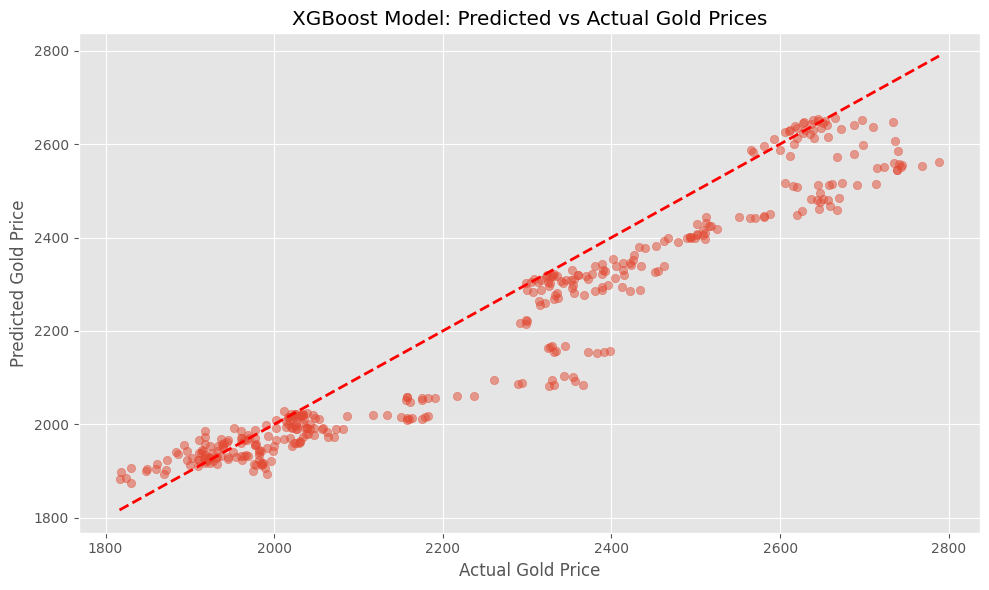

In [11]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import random

random.seed(42)
np.random.seed(42)
warnings.filterwarnings('ignore')
plt.style.use('ggplot')


#######################################
# Data Loading
#######################################
def load_data(file_path):
    df = pd.read_csv(file_path)
    selected_columns = ['Date', 'Gold', 'Silver', 'Crude Oil', 'DXY', 'S&P500', 'cpi', 'rates']
    df = df[selected_columns].copy()
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df.dropna(inplace=True)
    return df


#######################################
# Enhanced Feature Engineering
#######################################
def enhanced_feature_engineering(df):
    """Enhanced feature engineering addressing the identified issues"""
    result = df.copy()

    # 1. Log transform price levels for better statistical properties
    for col in ['Gold', 'Silver', 'Crude Oil', 'DXY', 'S&P500']:
        if col in result.columns:
            result[f'{col}_Log'] = np.log(result[col])

    # 2. Add trend features to capture directionality
    result['Time_Index'] = np.arange(len(result))
    result['Time_Index_Scaled'] = result['Time_Index'] / len(result)

    # 3. External predictors
    external_cols = ['Silver', 'DXY', 'Crude Oil', 'rates', 'cpi', 'S&P500']

    for col in external_cols:
        if col in result.columns:
            # Return-based features (better statistical properties than changes)
            for period in [1, 5, 10, 20]:
                result[f'{col}_Return_{period}d'] = result[col].pct_change(periods=period)

            # Volatility indicators
            for window in [10, 20, 30]:
                result[f'{col}_Volatility_{window}d'] = result[col].pct_change().rolling(window=window).std()

            # Momentum indicators
            for period in [10, 20, 50]:
                result[f'{col}_Momentum_{period}d'] = (
                                                              result[col] - result[col].shift(period)
                                                      ) / result[col].shift(period)

    # 4. Important economic indicators
    if 'rates' in result.columns and 'cpi' in result.columns:
        result['Real_Rate'] = result['rates'] - result['cpi']
        result['Real_Rate_Change'] = result['Real_Rate'].diff()
        # Add non-linear transformations for real rates
        result['Real_Rate_Squared'] = result['Real_Rate'] ** 2

    # 5. Market regime indicators
    if 'S&P500' in result.columns:
        # Bull/bear market indicator
        result['Market_Trend'] = result['S&P500'].pct_change(20).apply(
            lambda x: 1 if x > 0 else (-1 if x < 0 else 0)
        )

    # 6. Cross-asset relationships (avoiding using Gold in calculations)
    if 'Silver' in result.columns and 'DXY' in result.columns:
        result['Silver_DXY_Ratio'] = result['Silver'] / result['DXY']
        result['Silver_DXY_Ratio_Change'] = result['Silver_DXY_Ratio'].pct_change()

    if 'Silver' in result.columns and 'Crude Oil' in result.columns:
        result['Silver_Oil_Ratio'] = result['Silver'] / result['Crude Oil']
        result['Silver_Oil_Ratio_Change'] = result['Silver_Oil_Ratio'].pct_change()

    # 7. Seasonality (avoid using explicit year to prevent capturing a simple trend)
    result['Month'] = result['Date'].dt.month
    result['Quarter'] = result['Date'].dt.quarter
    # Convert to cyclical features
    result['Month_Sin'] = np.sin(2 * np.pi * result['Month'] / 12)
    result['Month_Cos'] = np.cos(2 * np.pi * result['Month'] / 12)

    # 8. Calendar effects for financial markets
    result['Day_Of_Week'] = result['Date'].dt.dayofweek

    # Remove columns with NaN values
    result.dropna(inplace=True)

    return result


#######################################
# Bias-Corrected Prediction with Recalibration
#######################################
class GoldPricePredictor:
    def __init__(self, recalibration_window=20, use_log_transform=True):
        self.rf_model = None
        self.feature_scaler = None
        self.target_scaler = None
        self.features = None
        self.recalibration_window = recalibration_window
        self.use_log_transform = use_log_transform
        self.bias_correction = 0
        self.bias_history = []

    def fit(self, X_train, y_train, features):
        """Fit the model on training data"""
        self.features = features

        # Apply log transformation if enabled
        if self.use_log_transform:
            y_train = np.log(y_train)

        # Scale features
        self.feature_scaler = RobustScaler()  # More robust to outliers
        X_train_scaled = self.feature_scaler.fit_transform(X_train)

        # Scale target
        self.target_scaler = StandardScaler()
        y_train_scaled = self.target_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()

        # Define model with optimal parameters
        self.rf_model = xgb.XGBRegressor(
            n_estimators=200,
            max_depth=15,
            min_samples_split=20,
            min_samples_leaf=10,
            max_features=0.7,
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        )

        # Fit model
        self.rf_model.fit(X_train_scaled, y_train_scaled)

        # Calculate initial bias on training data
        y_train_pred = self.predict_without_correction(X_train)
        self.bias_correction = np.mean(y_train - y_train_pred)
        print(f"Initial bias correction: {self.bias_correction:.4f}")

        return self

    def predict_without_correction(self, X):
        """Make predictions without bias correction"""
        X_scaled = self.feature_scaler.transform(X)
        y_pred_scaled = self.rf_model.predict(X_scaled)
        y_pred = self.target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        # Inverse log transform if enabled
        if self.use_log_transform:
            y_pred = np.exp(y_pred)

        return y_pred

    def predict(self, X, recalibrate=False, actual_values=None):
        """Make predictions with bias correction"""
        # Base prediction
        y_pred = self.predict_without_correction(X)

        # Apply bias correction
        y_pred_corrected = y_pred + self.bias_correction

        # Recalibrate if requested and actual values are provided
        if recalibrate and actual_values is not None:
            # Update bias correction based on recent observations
            recent_errors = actual_values - y_pred[:len(actual_values)]
            recent_bias = np.mean(recent_errors[-self.recalibration_window:])
            self.bias_history.append(recent_bias)

            # Exponential smoothing for bias correction
            alpha = 0.3  # Smoothing factor
            self.bias_correction = alpha * recent_bias + (1 - alpha) * self.bias_correction

            # Apply updated correction
            y_pred_corrected = y_pred + self.bias_correction
            print(f"Recalibrated bias correction: {self.bias_correction:.4f}")

        return y_pred_corrected

    def evaluate(self, X_test, y_test, recalibrate=True):
        """Evaluate model performance with detailed metrics"""
        # Initial prediction without recalibration
        y_pred_initial = self.predict(X_test)

        # Calculate metrics for initial predictions
        initial_r2 = r2_score(y_test, y_pred_initial)
        initial_explained_variance = explained_variance_score(y_test, y_pred_initial)
        initial_mae = mean_absolute_error(y_test, y_pred_initial)
        initial_mse = mean_squared_error(y_test, y_pred_initial)
        initial_rmse = np.sqrt(initial_mse)
        initial_mape = np.mean(np.abs((y_test - y_pred_initial) / y_test)) * 100

        print("\nInitial Prediction Metrics:")
        print(f"R²: {initial_r2:.5f}")
        print(f"Explained Variance Score: {initial_explained_variance:.5f}")
        print(f"MAE: {initial_mae:.2f}")
        print(f"MSE: {initial_mse:.2f}")
        print(f"RMSE: {initial_rmse:.2f}")
        print(f"MAPE: {initial_mape:.2f}%")

        # If recalibration is enabled, perform recalibration prediction
        if recalibrate:
            y_recalib = []
            for i in range(0, len(X_test), self.recalibration_window):
                # Get the current batch
                end_idx = min(i + self.recalibration_window, len(X_test))
                X_batch = X_test[i:end_idx]
                # Predict with current calibration
                y_batch_pred = self.predict(X_batch)
                y_recalib.extend(y_batch_pred)
                # Recalibrate using actual values if we have more batches to process
                if end_idx < len(X_test):
                    self.predict(X_batch, recalibrate=True, actual_values=y_test[i:end_idx])

            # Calculate metrics for recalibrated predictions
            recalib_r2 = r2_score(y_test, y_recalib)
            recalib_explained_variance = explained_variance_score(y_test, y_recalib)
            recalib_mae = mean_absolute_error(y_test, y_recalib)
            recalib_mse = mean_squared_error(y_test, y_recalib)
            recalib_rmse = np.sqrt(recalib_mse)
            recalib_mape = np.mean(np.abs((y_test - y_recalib) / y_test)) * 100

            print("\nRecalibrated Prediction Metrics:")
            print(f"R²: {recalib_r2:.5f}")
            print(f"Explained Variance Score: {recalib_explained_variance:.5f}")
            print(f"MAE: {recalib_mae:.2f}")
            print(f"MSE: {recalib_mse:.2f}")
            print(f"RMSE: {recalib_rmse:.2f}")
            print(f"MAPE: {recalib_mape:.2f}%")

            return {
                'initial_metrics': {
                    'r2': initial_r2,
                    'explained_variance': initial_explained_variance,
                    'mae': initial_mae,
                    'mse': initial_mse,
                    'rmse': initial_rmse,
                    'mape': initial_mape
                },
                'recalibrated_metrics': {
                    'r2': recalib_r2,
                    'explained_variance': recalib_explained_variance,
                    'mae': recalib_mae,
                    'mse': recalib_mse,
                    'rmse': recalib_rmse,
                    'mape': recalib_mape
                },
                'predictions': {
                    'initial': y_pred_initial,
                    'recalibrated': y_recalib
                }
            }

        return {
            'initial_metrics': {
                'r2': initial_r2,
                'explained_variance': initial_explained_variance,
                'mae': initial_mae,
                'mse': initial_mse,
                'rmse': initial_rmse,
                'mape': initial_mape
            },
            'predictions': {
                'initial': y_pred_initial
            }
        }

    def plot_feature_importance(self, n=15):
        """Plot feature importances from the model"""
        if self.rf_model is None or self.features is None:
            print("Model not trained yet!")
            return

        importances = self.rf_model.feature_importances_
        feature_importance = pd.DataFrame({
            'Feature': self.features,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        print(f"\nTop {n} Most Important Features:")
        print(feature_importance.head(n))

        plt.figure(figsize=(12, 8))
        plt.barh(feature_importance['Feature'].head(n), feature_importance['Importance'].head(n))
        plt.title(f'Top {n} Features for Predicting Gold Price')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

        return feature_importance

#######################################
def plot_predictions_vs_actual(y_test, y_pred, model_name="RF Model"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    # Plot the diagonal line for reference
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
    plt.xlabel("Actual Gold Price")
    plt.ylabel("Predicted Gold Price")
    plt.title(f"{model_name}: Predicted vs Actual Gold Prices")
    plt.tight_layout()
    plt.show()

#######################################
# Main Function
#######################################
def main():
    print("Loading data...")
    df = load_data('dataset/combined_dataset.csv')
    print(f"Dataset shape: {df.shape}")

    # Process features with enhanced engineering
    print("\nApplying enhanced feature engineering...")
    processed_df = enhanced_feature_engineering(df)
    processed_df.dropna(inplace=True)

    # Split data
    n = len(processed_df)
    train_ratio = 0.7
    val_ratio = 0.15
    train_cutoff = int(n * train_ratio)
    val_cutoff = int(n * (train_ratio + val_ratio))

    train_df = processed_df.iloc[:train_cutoff].copy()
    val_df = processed_df.iloc[train_cutoff:val_cutoff].copy()
    test_df = processed_df.iloc[val_cutoff:].copy()

    # Remove features that directly contain Gold or are time-based leakage
    leakage_features = ['Gold', 'Gold_Log', 'Date', 'Time_Index']
    features = [col for col in train_df.columns if col not in leakage_features]

    print(f"\nUsing {len(features)} features for prediction")

    # Prepare data
    X_train = train_df[features].values
    y_train = train_df['Gold'].values
    X_val = val_df[features].values
    y_val = val_df['Gold'].values
    X_test = test_df[features].values
    y_test = test_df['Gold'].values

    # Train and evaluate the model
    print("\nTraining gold price predictor with bias correction...")
    predictor = GoldPricePredictor(recalibration_window=10, use_log_transform=True)
    predictor.fit(X_train, y_train, features)

    # Validate on validation set
    print("\nEvaluating on validation set...")
    val_results = predictor.evaluate(X_val, y_val, recalibrate=True)

    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_results = predictor.evaluate(X_test, y_test, recalibrate=True)

    # Plot predictions vs actual
    plot_predictions_vs_actual(y_test, test_results['predictions']['recalibrated'], model_name="XGBoost Model")

    return predictor, test_results


if __name__ == "__main__":
    main()

## Neural Network

Loading data...

Dataset shape: (2513, 8)

Preparing data for modeling with train/validation/test split...
- S&P500
- Silver
Final features used in model training:
- Crude Oil
- DXY
- cpi
- rates
- Silver_Lag_1
- Silver_Pct_1
- Silver_Lag_3
- Silver_Pct_3
- DXY_Lag_1
- DXY_Pct_1
- DXY_Lag_3
- DXY_Pct_3
- Crude Oil_Lag_1
- Crude Oil_Pct_1
- Crude Oil_Lag_3
- Crude Oil_Pct_3
- rates_Lag_1
- rates_Pct_1
- rates_Lag_3
- rates_Pct_3
- cpi_Lag_1
- cpi_Pct_1
- cpi_Lag_3
- cpi_Pct_3
- DXY_ROC_5
- rates_ROC_5
- cpi_ROC_5
- real_rate

Running time series cross-validation with feature selection...

Fold 1/5
Train: samples 0 to 2213
Test: samples 2214 to 2263

Top 8 features selected:
- Silver_Lag_1: 7025.3342
- Silver_Lag_3: 6697.1470
- real_rate: 6568.7923
- cpi: 5681.7373
- cpi_Lag_1: 5671.5587
- cpi_Lag_3: 5652.1544
- Crude Oil: 722.3024
- Crude Oil_Lag_1: 717.3854
Epoch [0/100], Train Loss: 0.6167, Val Loss: 0.2689, LR: 0.100000
Epoch [20/100], Train Loss: 0.4863, Val Loss: 0.5405, LR: 0.0250

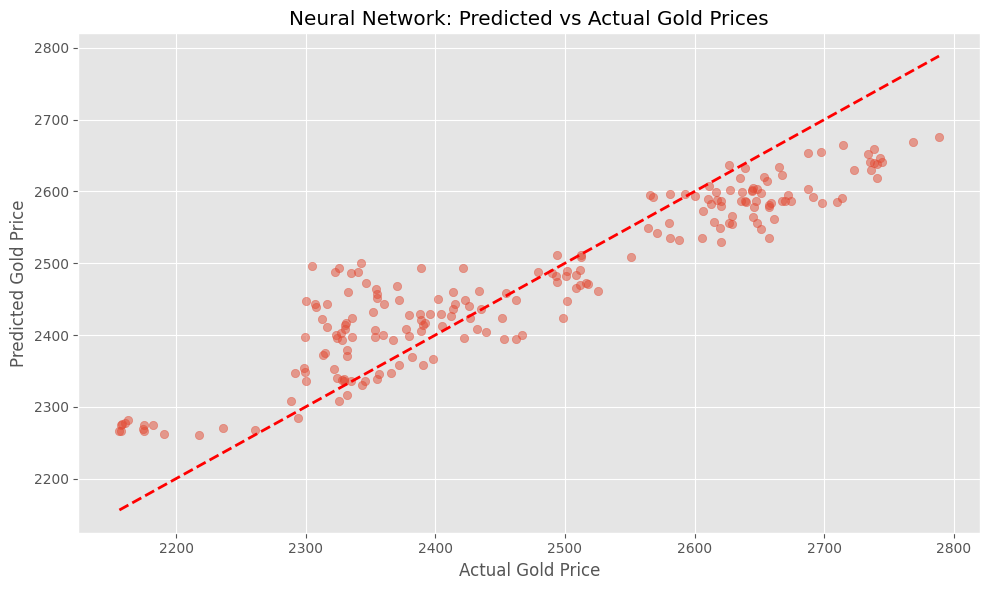

In [ ]:
import warnings
import matplotlib
import random
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Set all random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

#######################################
# Neural Network Model Definition with BatchNorm and Dropout
#######################################
class GoldPriceNN(nn.Module):
    def __init__(self, input_size):
        super(GoldPriceNN, self).__init__()
        # Minimal architecture
        self.layer1 = nn.Linear(input_size, 4)  # Only 4 hidden units
        self.layer2 = nn.Linear(4, 1)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x
#######################################
# Dataset Class
#######################################
class GoldDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y).reshape(-1, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#######################################
# Feature Engineering
#######################################
def process_features(df):
    """More conservative feature engineering approach"""
    result = df.copy()

    # Only create the most important features
    numerical_cols = ['Silver', 'DXY', 'Crude Oil', 'rates', 'cpi']
    for feature in numerical_cols:
        if feature in result.columns:
            # Just simple lags and percent changes
            for lag in [1, 3]:
                result[f'{feature}_Lag_{lag}'] = result[feature].shift(lag)
                result[f'{feature}_Pct_{lag}'] = result[feature].pct_change(periods=lag)
    result['Gold_Price_Trend'] = result['Gold'].diff(20).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

    # Rate of change features for key variables
    for feature in ['DXY', 'rates', 'cpi']:
        if feature in result.columns:
            result[f'{feature}_ROC_5'] = result[feature].pct_change(5) * 100
    # Just a few technical features for Gold
    if 'Gold' in result.columns:
        # Moving averages (avoid complex derivatives)
        for window in [20, 50]:
            result[f'Gold_MA_{window}'] = result['Gold'].rolling(window=window).mean()

        # Simple volatility measure
        result['Gold_Vol_20d'] = result['Gold'].pct_change().rolling(window=20).std()

    # A couple of key ratio features
    if 'DXY' in result.columns and 'Gold' in result.columns:
        result['Gold_DXY_Ratio'] = result['Gold'] / result['DXY']

    if 'cpi' in result.columns and 'rates' in result.columns:
        result['real_rate'] = result['rates'] - result['cpi']

    # Remove potential leakage columns
    leakage_cols = ['Silver', 'S&P500']
    result = result.drop(leakage_cols, axis=1)

    return result

#######################################
# Data Preparation
#######################################
def prepare_data(df, train_ratio=0.7, val_ratio=0.15):
    """Split the data into train/validation/test sets and process features"""
    df_sorted = df.sort_values('Date')
    # (Optional) print warnings for very high correlations
    corr_with_gold = df_sorted.corr()['Gold'].abs().sort_values(ascending=False)
    high_corr_features = [f for f in corr_with_gold[corr_with_gold > 0.9].index.tolist() if f not in ['Gold', 'Date']]
    if high_corr_features:
        print("WARNING: The following features have very high correlation with Gold (potential leakage):")
        for feature in high_corr_features:
            print(f"- {feature}")
    n = len(df_sorted)
    train_cutoff = int(n * train_ratio)
    val_cutoff = int(n * (train_ratio + val_ratio))
    train_df = df_sorted.iloc[:train_cutoff].copy()
    val_df = df_sorted.iloc[train_cutoff:val_cutoff].copy()
    test_df = df_sorted.iloc[val_cutoff:].copy()
    train_df = process_features(train_df)
    val_df = process_features(val_df)
    test_df = process_features(test_df)
    train_df.dropna(inplace=True)
    val_df.dropna(inplace=True)
    test_df.dropna(inplace=True)
    # Build final feature list (exclude Gold and Date)
    feature_columns = [col for col in train_df.columns if col not in ['Gold', 'Date'] and 'Gold' not in col]
    features = list(dict.fromkeys(feature_columns))  # Remove duplicates
    print("Final features used in model training:")
    for f in features:
        print(f"- {f}")
    X_train = train_df[features].values
    y_train = train_df['Gold'].values
    X_val = val_df[features].values
    y_val = val_df['Gold'].values
    X_test = test_df[features].values
    y_test = test_df['Gold'].values
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_val_scaled = feature_scaler.transform(X_val)
    X_test_scaled = feature_scaler.transform(X_test)
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
    y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).ravel()
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).ravel()
    train_dataset = GoldDataset(X_train_scaled, y_train_scaled)
    val_dataset = GoldDataset(X_val_scaled, y_val_scaled)
    test_dataset = GoldDataset(X_test_scaled, y_test_scaled)
    return train_dataset, val_dataset, test_dataset, feature_scaler, target_scaler, features

def load_data(file_path):
    df = pd.read_csv(file_path)
    selected_columns = ['Date', 'Gold', 'Silver', 'Crude Oil', 'DXY', 'S&P500', 'cpi', 'rates']
    df = df[selected_columns].copy()
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df.dropna(inplace=True)
    return df

#######################################
# Feature Selection using SelectKBest
#######################################
def select_top_features(X_train, y_train, features, k=8, method='combined'):
    if method == 'mutual_info':
        selector = SelectKBest(mutual_info_regression, k=k)
    else:
        selector = SelectKBest(f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    feature_mask = selector.get_support()
    selected_features = [features[i] for i in range(len(features)) if feature_mask[i]]
    scores = selector.scores_
    feature_scores = [(features[i], scores[i]) for i in range(len(features))]
    feature_scores.sort(key=lambda x: x[1], reverse=True)
    print(f"\nTop {k} features selected:")
    for feature, score in feature_scores[:k]:
        print(f"- {feature}: {score:.4f}")
    return selected_features, X_train_selected, feature_mask

#######################################
# Time Series Cross-Validation with Feature Selection
#######################################
def time_series_cv(df, features, target='Gold', n_splits=5, test_size=50):
    df_sorted = df.sort_values('Date').reset_index(drop=True)
    df_processed = process_features(df_sorted)
    df_processed.dropna(inplace=True)
    cv_results = {'train_r2': [], 'test_r2': [], 'train_rmse': [], 'test_rmse': [], 'selected_features': []}
    n_samples = len(df_processed)
    indices = []
    for i in range(n_splits):
        test_end = n_samples - i * test_size
        test_start = test_end - test_size
        if test_start <= 0:
            continue
        indices.append((0, test_start, test_start, test_end))
    indices.reverse()
    for i, (train_start, train_end, test_start, test_end) in enumerate(indices):
        print(f"\nFold {i + 1}/{len(indices)}")
        print(f"Train: samples {train_start} to {train_end - 1}")
        print(f"Test: samples {test_start} to {test_end - 1}")
        train_df = df_processed.iloc[train_start:train_end]
        test_df = df_processed.iloc[test_start:test_end]
        X_train = train_df[features].values
        y_train = train_df[target].values
        X_test = test_df[features].values
        y_test = test_df[target].values
        k = min(8, len(features))
        selected_features, X_train_selected, feature_mask = select_top_features(X_train, y_train, features, k=k)
        X_test_selected = X_test[:, feature_mask]
        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train_selected)
        X_test_scaled = scaler_X.transform(X_test_selected)
        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()
        train_dataset_cv = GoldDataset(X_train_scaled, y_train_scaled)
        test_dataset_cv = GoldDataset(X_test_scaled, y_test_scaled)
        input_size = X_train_selected.shape[1]
        model, _, _ = train_neural_network(train_dataset_cv, test_dataset_cv, input_size, epochs=100)
        model.eval()

        with torch.no_grad():
            y_train_pred = model(torch.FloatTensor(X_train_scaled)).numpy().flatten()
            y_test_pred = model(torch.FloatTensor(X_test_scaled)).numpy().flatten()
        train_r2 = r2_score(y_train_scaled, y_train_pred)
        test_r2 = r2_score(y_test_scaled, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train_scaled, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test_scaled, y_test_pred))
        cv_results['train_r2'].append(train_r2)
        cv_results['test_r2'].append(test_r2)
        cv_results['train_rmse'].append(train_rmse)
        cv_results['test_rmse'].append(test_rmse)
        cv_results['selected_features'].append(selected_features)
        print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
        print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    avg_train_r2 = np.mean(cv_results['train_r2'])
    avg_test_r2 = np.mean(cv_results['test_r2'])
    avg_train_rmse = np.mean(cv_results['train_rmse'])
    avg_test_rmse = np.mean(cv_results['test_rmse'])
    print("\nAverage Cross-Validation Results:")
    print(f"Train R²: {avg_train_r2:.4f}, Test R²: {avg_test_r2:.4f}")
    print(f"Train RMSE: {avg_train_rmse:.4f}, Test RMSE: {avg_test_rmse:.4f}")
    print("\nFeature Selection Frequency:")
    feature_counts = {}
    for f_list in cv_results['selected_features']:
        for feat in f_list:
            feature_counts[feat] = feature_counts.get(feat, 0) + 1
    for feat, count in sorted(feature_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"- {feat}: {count}/{len(indices)} folds")
    return cv_results

#######################################
# Neural Network Training with L1 Regularization and Adam Optimizer
#######################################

def train_neural_network(train_dataset, val_dataset, input_size, epochs=200):
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0,drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), num_workers=0)
    model = GoldPriceNN(input_size)
    # Use Adam optimizer with higher weight decay for stronger regularization
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    criterion = nn.MSELoss()
    l1_lambda = 0.1
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    patience = 40
    patience_counter = 0
    best_model = None
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.reshape(-1, 1))
            l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())
            loss = loss + l1_lambda * l1_norm
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        model.eval()
        with torch.no_grad():
            X_val, y_val = next(iter(val_loader))
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val.reshape(-1, 1))
        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(val_loss.item())
        scheduler.step(val_loss)
        if epoch % 20 == 0:
            print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            best_model = model.state_dict().copy()
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    if best_model is not None:
        model.load_state_dict(best_model)
    return model, train_losses, val_losses


def evaluate_nn(y_train, y_train_pred, y_test, y_test_pred):
    # Calculate metrics for training data
    train_r2 = r2_score(y_train, y_train_pred)
    train_evs = explained_variance_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

    # Calculate metrics for testing data
    test_r2 = r2_score(y_test, y_test_pred)
    test_evs = explained_variance_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

    print("\nFinal Neural Network Model Results (Selected Features):")
    print(f"Training R²: {train_r2:.5f}  |  Test R²: {test_r2:.5f}")
    print(f"Training EVS: {train_evs:.5f}  |  Test EVS: {test_evs:.5f}")
    print(f"Training MAE: {train_mae:.2f}  |  Test MAE: {test_mae:.2f}")
    print(f"Training MSE: {train_mse:.2f}  |  Test MSE: {test_mse:.2f}")
    print(f"Training RMSE: {train_rmse:.2f}  |  Test RMSE: {test_rmse:.2f}")
    print(f"Training MAPE: {train_mape:.2f}%  |  Test MAPE: {test_mape:.2f}%")

    return {
        'train': {
            'R2': train_r2,
            'EVS': train_evs,
            'MAE': train_mae,
            'MSE': train_mse,
            'RMSE': train_rmse,
            'MAPE': train_mape,
        },
        'test': {
            'R2': test_r2,
            'EVS': test_evs,
            'MAE': test_mae,
            'MSE': test_mse,
            'RMSE': test_rmse,
            'MAPE': test_mape,
        }
    }

#######################################
# Main Function
#######################################
def main():
    print("Loading data...")
    df = load_data('dataset/combined_dataset.csv')
    print(f"\nDataset shape: {df.shape}")
    print("\nPreparing data for modeling with train/validation/test split...")
    train_dataset, val_dataset, test_dataset, feature_scaler, target_scaler, features = prepare_data(
        df, train_ratio=0.7, val_ratio=0.2)
    print("\nRunning time series cross-validation with feature selection...")
    cv_results = time_series_cv(df, features, n_splits=5, test_size=50)
    feature_counts = {}
    for feat_list in cv_results['selected_features']:
        for feat in feat_list:
            feature_counts[feat] = feature_counts.get(feat, 0) + 1
    top_features = [f for f, count in sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)[:8]]
    print("\nTop features across CV folds:")
    for feature in top_features:
        print(f"- {feature}")
    print("\nTraining final model with selected features...")
    X_train = train_dataset.X.numpy()
    y_train = train_dataset.y.numpy()
    X_test = test_dataset.X.numpy()
    y_test = test_dataset.y.numpy()
    selected_indices = [features.index(f) for f in top_features if f in features]
    X_train_selected = X_train[:, selected_indices]
    X_test_selected = X_test[:, selected_indices]
    train_dataset_selected = GoldDataset(X_train_selected, y_train)
    test_dataset_selected = GoldDataset(X_test_selected, y_test)
    input_size = len(top_features)
    model, train_losses, val_losses = train_neural_network(train_dataset_selected, test_dataset_selected, input_size, epochs = 50)
    model.eval()
    with torch.no_grad():
        y_test_pred = model(torch.FloatTensor(X_test_selected)).numpy().flatten()

    # Transform predictions and actual values back to the original scale
    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_test_pred_original = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

    # Compute metrics on the original scale
    r2_orig = r2_score(y_test_original, y_test_pred_original)
    mae_orig = mean_absolute_error(y_test_original, y_test_pred_original)
    mse_orig = mean_squared_error(y_test_original, y_test_pred_original)
    rmse_orig = np.sqrt(mse_orig)

    print("\nMetrics on Original Scale (Neural Network):")
    print(f"R²: {r2_orig:.5f}")
    print(f"MAE: {mae_orig:.2f}")
    print(f"MSE: {mse_orig:.2f}")
    print(f"RMSE: {rmse_orig:.2f}")
    print("EVS: ", explained_variance_score(y_test_original, y_test_pred_original))

    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_test_pred_original = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_original, y_test_pred_original, alpha=0.5)
    plt.plot([y_test_original.min(), y_test_original.max()],
             [y_test_original.min(), y_test_original.max()],
             'r--', lw=2)
    plt.xlabel('Actual Gold Price')
    plt.ylabel('Predicted Gold Price')
    plt.title('Neural Network: Predicted vs Actual Gold Prices')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

## SVM

Loading data...

Preparing data...

Features used:
1. Crude Oil
2. DXY
3. cpi
4. rates
5. RSI_14
6. RSI_21
7. Gold_MA_5
8. Gold_MA_Ratio_5
9. Gold_MA_10
10. Gold_MA_Ratio_10
11. Gold_MA_20
12. Gold_MA_Ratio_20
13. Gold_MA_30
14. Gold_MA_Ratio_30
15. Gold_Volatility_20
16. Gold_Volatility_30
17. Gold_ROC_5
18. Gold_ROC_10
19. Gold_ROC_20
20. DXY_MA_10
21. DXY_MA_20
22. DXY_ROC_10
23. DXY_ROC_20
24. Oil_MA_10
25. Oil_MA_20
26. Oil_ROC_10
27. Oil_ROC_20
28. Real_Rate
29. Real_Rate_Change
30. CPI_Change

Data shapes:
X_train: (2009, 30)
y_train: (2009,)
X_val: (251, 30)
y_val: (251,)
X_test: (252, 30)
y_test: (252,)

Tuning model...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'C': 100.0, 'epsilon': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.7997

Evaluating final model...

Model Evaluation Results:
R-squared (R²): 0.8599
Explained Variance Score: 0.9446
Mean Absolute Error: 64.93
Mean Squared Error: 6962.45
Root Mean Squared E

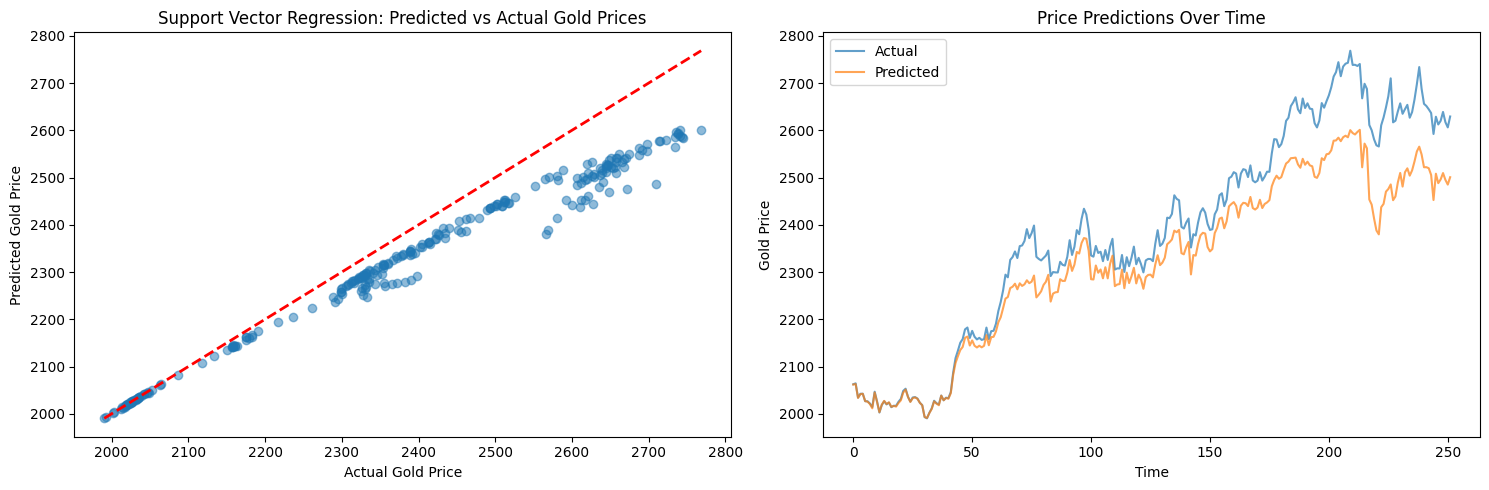

In [5]:
import warnings
import matplotlib
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset

#######################################
# Dataset Class
#######################################
class GoldDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#######################################
# Data Preparation Functions
#######################################
def load_data(file_path):
    df = pd.read_csv(file_path)
    selected_columns = ['Date', 'Gold', 'Silver', 'Crude Oil', 'DXY', 'S&P500', 'cpi', 'rates']
    df = df[selected_columns].copy()
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df.dropna(inplace=True)
    return df

def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def process_features(df, remove_gold=False):
    """Refined feature engineering"""
    result = df.copy()

    # Technical indicators for Gold
    if 'Gold' in result.columns:
        # RSI with different periods
        result['RSI_14'] = calculate_rsi(result['Gold'], periods=14)
        result['RSI_21'] = calculate_rsi(result['Gold'], periods=21)

        # Moving averages and ratios
        for window in [5, 10, 20, 30]:
            result[f'Gold_MA_{window}'] = result['Gold'].rolling(window=window).mean()
            result[f'Gold_MA_Ratio_{window}'] = result['Gold'] / result[f'Gold_MA_{window}']

        # Volatility indicators
        result['Gold_Volatility_20'] = result['Gold'].rolling(window=20).std()
        result['Gold_Volatility_30'] = result['Gold'].rolling(window=30).std()

        # Price momentum
        for period in [5, 10, 20]:
            result[f'Gold_ROC_{period}'] = result['Gold'].pct_change(period)

    # Market indicators
    if 'DXY' in result.columns:
        result['DXY_MA_10'] = result['DXY'].rolling(window=10).mean()
        result['DXY_MA_20'] = result['DXY'].rolling(window=20).mean()
        result['DXY_ROC_10'] = result['DXY'].pct_change(10)
        result['DXY_ROC_20'] = result['DXY'].pct_change(20)

    if 'Crude Oil' in result.columns:
        result['Oil_MA_10'] = result['Crude Oil'].rolling(window=10).mean()
        result['Oil_MA_20'] = result['Crude Oil'].rolling(window=20).mean()
        result['Oil_ROC_10'] = result['Crude Oil'].pct_change(10)
        result['Oil_ROC_20'] = result['Crude Oil'].pct_change(20)

    # Economic indicators
    if all(col in result.columns for col in ['rates', 'cpi']):
        result['Real_Rate'] = result['rates'] - result['cpi']
        result['Real_Rate_Change'] = result['Real_Rate'].diff()
        result['CPI_Change'] = result['cpi'].pct_change()

    # Handle missing values
    result = result.fillna(method='ffill').fillna(method='bfill')

    return result

def prepare_data(df, train_ratio=0.8, val_ratio=0.1):
    """Improved data preparation"""
    df_sorted = df.sort_values('Date')

    # Process features first
    processed_df = process_features(df_sorted, remove_gold=False)
    processed_df.dropna(inplace=True)

    # Split data
    n = len(processed_df)
    train_cutoff = int(n * train_ratio)
    val_cutoff = int(n * (train_ratio + val_ratio))

    train_df = processed_df.iloc[:train_cutoff].copy()
    val_df = processed_df.iloc[train_cutoff:val_cutoff].copy()
    test_df = processed_df.iloc[val_cutoff:].copy()

    # Define features to keep
    feature_columns = [col for col in processed_df.columns
                      if col not in ['Date', 'Gold', 'Silver', 'S&P500']
                      and not col.startswith('Unnamed')]

    # Extract features and target
    X_train = train_df[feature_columns].values
    X_val = val_df[feature_columns].values
    X_test = test_df[feature_columns].values

    y_train = train_df['Gold'].values
    y_val = val_df['Gold'].values
    y_test = test_df['Gold'].values

    # Print feature importance if requested
    print("\nFeatures used:")
    for i, feature in enumerate(feature_columns):
        print(f"{i+1}. {feature}")

    # Scale features
    feature_scaler = RobustScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_val_scaled = feature_scaler.transform(X_val)
    X_test_scaled = feature_scaler.transform(X_test)

    # Scale target
    target_scaler = RobustScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
    y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).ravel()
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).ravel()

    return (X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled,
            X_test_scaled, y_test_scaled, feature_scaler, target_scaler, feature_columns)

def tune_model(X_train, y_train, X_val, y_val):
    """Enhanced model tuning"""
    param_grid = {
        'C': [1.0, 10.0, 100.0, 1000.0],
        'epsilon': [0.001, 0.01, 0.1],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf'],
    }

    model = SVR()
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='r2',  # Changed to R2 scoring
        n_jobs=-1,
        verbose=1
    )

    # Combine train and validation data
    X_combined = np.vstack([X_train, X_val])
    y_combined = np.concatenate([y_train, y_val])

    grid_search.fit(X_combined, y_combined)

    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

def evaluate_model(model, test_dataset, target_scaler):
    """Enhanced model evaluation"""
    X_test_np = test_dataset.X.numpy()
    y_test_np = test_dataset.y.numpy().reshape(-1)

    # Make predictions
    y_pred_scaled = model.predict(X_test_np)

    # Inverse transform predictions and actual values
    y_pred_original = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(-1)
    y_test_original = target_scaler.inverse_transform(y_test_np.reshape(-1, 1)).reshape(-1)

    # Calculate metrics
    r2 = r2_score(y_test_original, y_pred_original)
    evs = explained_variance_score(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

    print("\nModel Evaluation Results:")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Explained Variance Score: {evs:.4f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")

    # Create visualization
    plt.figure(figsize=(15, 5))

    # Subplot 1: Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_test_original, y_pred_original, alpha=0.5)
    plt.plot([y_test_original.min(), y_test_original.max()],
             [y_test_original.min(), y_test_original.max()],
             'r--', lw=2)
    plt.xlabel('Actual Gold Price')
    plt.ylabel('Predicted Gold Price')
    plt.title('Support Vector Regression: Predicted vs Actual Gold Prices')

    # Subplot 2: Time series plot
    plt.subplot(1, 2, 2)
    plt.plot(y_test_original, label='Actual', alpha=0.7)
    plt.plot(y_pred_original, label='Predicted', alpha=0.7)
    plt.title('Price Predictions Over Time')
    plt.xlabel('Time')
    plt.ylabel('Gold Price')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'R2': r2,
        'EVS': evs,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

def main():
    print("Loading data...")
    df = load_data('dataset/combined_dataset.csv')

    # Remove outliers
    Q1 = df['Gold'].quantile(0.25)
    Q3 = df['Gold'].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df['Gold'] < (Q1 - 1.5 * IQR)) | (df['Gold'] > (Q3 + 1.5 * IQR)))]

    print("\nPreparing data...")
    (X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled,
     X_test_scaled, y_test_scaled, feature_scaler, target_scaler, features) = prepare_data(df)

    # Print shapes for debugging
    print(f"\nData shapes:")
    print(f"X_train: {X_train_scaled.shape}")
    print(f"y_train: {y_train_scaled.shape}")
    print(f"X_val: {X_val_scaled.shape}")
    print(f"y_val: {y_val_scaled.shape}")
    print(f"X_test: {X_test_scaled.shape}")
    print(f"y_test: {y_test_scaled.shape}")

    # Create datasets
    train_dataset = GoldDataset(X_train_scaled, y_train_scaled)
    val_dataset = GoldDataset(X_val_scaled, y_val_scaled)
    test_dataset = GoldDataset(X_test_scaled, y_test_scaled)

    print("\nTuning model...")
    best_model = tune_model(X_train_scaled, y_train_scaled,
                          X_val_scaled, y_val_scaled)

    print("\nEvaluating final model...")
    results = evaluate_model(best_model, test_dataset, target_scaler)

    return best_model, results

if __name__ == "__main__":
    main()